# Auxillary tutorial 6: Model selection with MCMC

*This document was generated from an IPython notebook.  You can download the notebook [here](aux6_model_selection_with_mcmc.ipynb).*

Before we begin, let's load the necessary modules, as usual.

In [1]:
# As usual, import modules
from __future__ import division, absolute_import, print_function
    
import numpy as np
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.special
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import numdifftools as nd

import emcee
import triangle
from brewer2mpl import qualitative, sequential

# Utilities from JB
import jb_utils as jb

# Necessary to display plots in this IPython notebook
%matplotlib inline    

In [Homework 5](http://bebi103.caltech.edu/homework/hw5.html), we considered the data from the [Gardner, Zanic, et al. paper](../protected/papers/gardner_2011.pdf) describing microtubule catastrophe times.  We performed model selection analysis by approximating the posterior distributions resulting from parameter estimation by regression to get approximate expressions for the odds ratio.  Now, we will use MCMC to do both parameter estimation and odds ratio calculation.

You can download the data set [here](../protected/data/gardner_hw5.zip).  In the file `gardner_mt_catastrophe_only_tubulin.csv`, we have observed catastrophe times of microtubules with different concentrations of tubulin.  So, our data set $D$ consists of a set of measurements of the amount of time to catastrophe; $D = \{t_i\}$.  

We will consider three models for microtubule catastrophe.  In the first model ($M_1$), our likelihood is exponential,

\begin{align}
P(D~|~\lambda, M_1, I) = \prod_{i\in D} \lambda \mathrm{e}^{-\lambda t_i}.
\end{align}

In the second model ($M_2$), the likelihood is gamma-distributed,

\begin{align}
P(D~|~r, a, M_2, I) = \prod_{i\in D} \frac{(rt_i)^a}{t_i\,\Gamma(a)}\,\mathrm{e}^{-rt_i},
\end{align}

where $\Gamma(a)$ is the gamma function.  Finally, in the third model ($M_3$), the likelihood is Weibull distributed (describing an aging process),

\begin{align}
P(D~|~\beta,\lambda,M_3,I) = \beta \lambda \left(\lambda t\right)^{\beta-1}
\mathrm{e}^{-(\lambda t)^\beta}.
\end{align}

We will consider catastrophe data for 12 µM tubulin.  We will estimate the parameter values for each model and then compute their odds ratio.  First, we'll go through the technique.

### Parameter estimation using parallel tempering

We will use results from MCMC calculations using parellel tempering (PTMCMC) to do our model selection.  But first, I will discuss how parallel tempering works.  Consider mode $M_i$ with parameters $\mathbf{a}_i$.  Then, the posterior distribution for the parameter estimation problem is

\begin{align}
P(\mathbf{a}_i~|~D,M_i,I) \propto P(\mathbf{a}_i~|~M_i,I)\, P(D~|~\mathbf{a}_i,M_i,I).
\end{align}

Now, we define

\begin{align}
\pi(\mathbf{a}_i~|~D,M_i,\beta, I) &= c\,P(\mathbf{a}_i~|~M_i,I)\, \left[P(D~|~\mathbf{a}_i,M_i,I)\right]^{\beta} \\[1mm]
&=  c\,P(\mathbf{a}_i~|~M_i,I)\,\exp\left\{\beta\ln P(D~|~\mathbf{a}_i,M_i,I)\right\},
\end{align}

where $c$ is just a normalization constant.  We see that $\beta$ is analogous to the inverse temperature from statistical themodynamics.  For PTMCMC, we take $\beta \in [0, 1]$.  For $\beta = 0$, we get that $\pi(\mathbf{a}_i~|~D,M_i,\beta, I) = P(\mathbf{a}_i~|~M_i,I)$, the prior distribution.  For $\beta = 1$, we get the "cold" distribution, which is our target posterior.

The idea behind PTMCMC is to sample $\pi(\mathbf{a}_i~|~D,M_i,\beta, I)$ distributions in parallel for various values of $\beta$.  For "hot" (small) values of $\beta$, the distribution is flatter than for cold values of $\beta$.  On occasion, the position of the walker in a hot sampling is swapped with that in a cold one.  This way, the sampler does not get trapped on local maxima.  When we are finished sampling, we take

\begin{align}
P(\mathbf{a}_i~|~D,M_i,I) = \pi(\mathbf{a}_i~|~D,M_i,\beta=0, I).
\end{align}

### Using PTMCMC traces to do model selection

By being clever, we can use all of those traces from the parameter estimation problem to do model selection.  This is so cool.

Consider again the model selection problem.  Recall that our goal is to compute  $P(M_i~|~D,I)$, the probability that model $M_i$ is true, given the data.  Using Bayes's theorem, 

\begin{align}
P(M_i~|~D,I) = \frac{P(M_i~|~I)}{P(D~|~I)}\,P(D~|~M_i,I).
\end{align}

Since we always compute odds ratios, $O_{ij} = P(M_i~|~D,I)~/~P(M_j~|~D,I)$, we do not need to concern ourselves with $P(D~|~I)$.  The factor $P(M_i~|~I)$ is our prior probability that $M_i$ is true.  So, we need to compute $P(D~|~M_i,I)$.  Now, recall Bayes's theorem for the parameter estimation problem,

\begin{align}
P(\mathbf{a}_i~|~D,M_i,I) =\frac{1}{P(D~|~M_i,I)}\, P(\mathbf{a}_i~|~M_i,I)\, P(D~|~\mathbf{a}_i,M_i,I).
\end{align}

We see that $P(D~|~M_i,I)$ is the evidence from the parameter estimation problem.  Since the posterior has to be normalized, we have

\begin{align}
P(D~|~M_i,I) = \int \mathrm{d}\mathbf{a}_i\,P(\mathbf{a}_i~|~M_i,I)\, P(D~|~\mathbf{a}_i,M_i,I).
\end{align}

So, our goal is to compute this integral.

Now, we define the partition function for model $M_i$, $Z_i(\beta)$ as

\begin{align}
Z_i(\beta) = \int \mathrm{d}\mathbf{a}_i\,P(\mathbf{a}_i~|~M_i,I)\, \left[P(D~|~\mathbf{a}_i,M_i,I)\right]^\beta
= \frac{1}{c}\int \mathrm{d}\mathbf{a}_i\, \pi(\mathbf{a}_i~|~D,M_i, \beta, I).
\end{align}

So, our goal is to compute $Z_i(1) = P(D~|~M_i,I)$.  This can be written as

\begin{align}
\ln Z_i(1) = \int_0^1 \mathrm{d}\beta \, \frac{\partial \ln Z_i(\beta)}{\partial \beta}
= \ln Z_i(1) - \ln Z_i(0),
\end{align}

since $Z_i(0) = 1$ because the prior is normalized.  So, we compute

\begin{align}
\frac{\partial \ln Z_i(\beta)}{\partial \beta} &= \frac{1}{Z_i}\,\frac{\partial Z_i}{\partial \beta}
= \frac{1}{Z_i}\,\frac{\partial}{\partial \beta}\left[\int\mathrm{d}\mathbf{a}_i\,P(\mathbf{a}_i~|~M_i,I)\,\exp\left\{\beta\ln P(D~|~\mathbf{a}_i,M_i,I)\right\}\right] \\[1mm]
&=\frac{1}{Z_i}\,\int\mathrm{d}\mathbf{a}_i\,\left[\ln P(D~|~\mathbf{a}_i,M_i,I)\right]\,P(\mathbf{a}_i~|~M_i,I)\,\exp\left\{\beta\ln P(D~|~\mathbf{a}_i,M_i,I)\right\} \\[1mm]
&=\frac{\int\mathrm{d}\mathbf{a}_i\,\left[\ln P(D~|~\mathbf{a}_i,M_i,I)\right]\,\pi(\mathbf{a}_i~|~D,M_i, \beta, I)}
{\int\mathrm{d}\mathbf{a}_i\,\pi(\mathbf{a}_i~|~D,M_i, \beta, I)} \\[1mm]
&= \left<\ln P(D~|~\mathbf{a}_i,M_i,I)\right>_\beta,
\end{align}

where we have noted in the last equality that we are computing the average log likelihood over the distribution $\pi(\mathbf{a}_i~|~D,M_i,\beta,I)$.  Remember that we're sampling $\pi(\mathbf{a}_i~|~D,M_i,\beta,I)$ for each $\beta$ while doing PTMCMC.  So, computing the mean of the log likelihood is trivial, since we're already sampling it!

So, we have

\begin{align}
\ln P(D~|~M_i,I) = \ln Z_i(1) = \int_0^1 \mathrm{d}\beta\,\left<\ln P(D~|~\mathbf{a}_i,M_i,I)\right>_\beta.
\end{align}

We easily compute $\left<\ln P(D~|~\mathbf{a}_i,M_i,I)\right>_\beta$ from our PTMCMC traces and then use a numerical quadrature technique to compute the integral.  Guess what.  As we'll see when we do the calculation, `emcee` has a built in function to do this integral!  (Though it's also not hard to do it ourselves.)

So, putting it all together, we can compute the log of the odds ratio as

\begin{align}
\ln O_{ij} = \ln P(M_i~|~I) - \ln P(M_j~|~I) + \ln Z_i(1) - \ln Z_j(1).
\end{align}

This is perhaps easiest seen by example.

### Analysis for microtubule castrophe data

Of course, the first thing we do is load the data.

In [82]:
# Load the data set
fname = '../data/gardner_et_al/gardner_mt_catastrophe_only_tubulin.csv'
df = pd.read_csv(fname, comment='#')

# Pull our t, and have it sorted for convenience
t = df['12 uM'].dropna().values
t.sort()

Next, we define the log likelihoods and log priors for our three models.  Note that the `PTSampler` in `emcee` requires the likelihood and priors, not just the posterior as in the `EnsembleSampler` we're used to using.  This makes sense, since we will be performing the quadrature over the log likelihood to compute the odds ratios.

In [83]:
# Define likelihood for Model 1
def log_like_exp(lam, t):
    """
    Returns the properly normalized log exponential distribution.
    """
    # Input is an array, so make a scalar
    lam = lam[0]

    # Check for non-negativity (will mess up log calcs)
    if (lam <= 0.0):
        return -np.inf

    return len(t) * np.log(lam) - lam * t.sum()

# Define log prior for Model 1
def log_prior_exp(lam):
    # Input is an array, so make a scalar
    lam = lam[0]

    if (lam <= 0.0):
        return -np.inf

    return -np.log(lam)

# Define log likelihood for Model 2
def log_like_gamma(p, t):
    """
    Returns log likelihood of properly normalized log gamma distribution.
    """
    # Check for non-negativity (will mess up log calcs)
    if (p <= 0.0).any():
        return -np.inf

    a, r = p
    n = len(t)
    return -n * scipy.special.gammaln(a) + n * a * np.log(r) \
                     + ((a - 1.0) * np.log(t) - r * t).sum()

# Define log prior for Model 2
def log_prior_gamma(p):
    if (p <= 0.0).any():
        return -np.inf

    a, r = p
    return -np.log(a * r)

# Define log likelihood for Model 3
def log_like_weibull(p, t):
    """
    Properly normalized log likelihood for Weibull distribution.
    """
    # Check for non-negativity (will mess up log calcs)
    if (p <= 0.0).any():
        return -np.inf

    beta, lam = p
    n = len(t)
    return (beta - 1.0) * np.log(lam * t).sum() + n * np.log(lam * beta) \
                - ((lam * t)**beta).sum()

# Define log prior for Model 3
def log_prior_weibull(p):
    if (p <= 0.0).any():
        return -np.inf

    beta, lam = p
    
    return -np.log(lam * beta)

Now that we have the likelihoods and priors defined, it's just a matter of setting up the MCMC calculations using `emcee`.  The only difference for doing the sampling is that we need to specify the number of temperatures we want to use.  `emcee` will automatically define the values of `beta` to use based on the number of temperatures we ask for.  Of course, our starting points for the walkers must now be a 3-dimensional array to include temperature as well.

We'll do the calculation for Model 1 (exponential) first.

In [63]:
# Set up parameters for MCMC calculation (just like usual)
n_dim = 1        # 1 total parameter, lambda
n_walkers = 50    # number of MCMC walkers
n_burn = 2000      # "burn-in" period to let chains stabilize
n_steps = 5000    # number of MCMC steps to take after burn-in

# The extra specification is the number of temperatures in the ladder
n_temps = 20

# Give the starting points of the samplers
p0 = np.random.exponential(0.001, size=(n_temps, n_walkers, n_dim))

# Instantiate sampler
sampler_exp = emcee.PTSampler(n_temps, n_walkers, n_dim, log_like_exp, 
                              log_prior_exp, loglargs=(t,))

# Do the burn-in
pos, lnprob, lnlike = sampler_exp.run_mcmc(p0, n_burn, storechain=False)

# Do the sampling
pos, lnprob, lnlike = sampler_exp.run_mcmc(pos, n_steps)

And now for Model 2 (Gamma).

In [64]:
# Gamma distrubtion MCMC
n_dim = 2  # Two parameters, a and r

# Give the starting points of the samplers
p0 = np.empty((n_temps, n_walkers, n_dim))
p0[:,:,0] = np.random.exponential(1.0, size=(n_temps,n_walkers))  # a
p0[:,:,1] = np.random.exponential(0.01, size=(n_temps,n_walkers)) # r

# Instantiate sampler
sampler_gamma = emcee.PTSampler(n_temps, n_walkers, n_dim, log_like_gamma, 
                                log_prior_gamma, loglargs=(t,))

# Do the burn-in
pos, lnprob, lnlike = sampler_gamma.run_mcmc(p0, n_burn, storechain=False)

# Do the sampling
pos, lnprob, lnlike = sampler_gamma.run_mcmc(pos, n_steps)

For this model, we'll do a quick check to make sure we get the same estimates for the parameters as we got in [the solutions to homework 5](http://bebi103.caltech.edu/2014/protected/hw_solutions/hw5_solution.html).  As we see in the triangle plot below, the marginalized distributions for $a$ and $r$ are approximately Gaussian, so we will report a $\pm$ one standard deviation credible region.


a = 2.91 +- 0.15
r = 0.0076 +- 0.0004 1/s



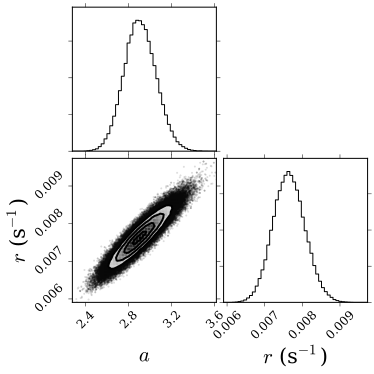

In [95]:
# Compute mean and std of a and r
a = sampler_gamma.flatchain[0,:,0].mean()
a_err = sampler_gamma.flatchain[0,:,0].std()
r = sampler_gamma.flatchain[0,:,1].mean()
r_err = sampler_gamma.flatchain[0,:,1].std()

# Print mean and std of $a$ and $r$
print("""
a = {0:.2f} +- {1:.2f}
r = {2:.4f} +- {3:.4f} 1/s
""".format(a, a_err, r, r_err))

# Make the triangle plot
triangle.corner(sampler_gamma.flatchain[0,:,:], 
                labels=['$a$', '$r$ (s$^{-1}$)']);

These results are in line with what we got in homework 5.

Finally for Model 3 (Weibull).  We're making sure not to confuse the parameter $\beta$ in the Weibull distribution from the inverse temperature used in the PTMCMC calculations.  This isn't a problem since we never actually see $\beta$ in our code, since `emcee` takes care of all of that under the hood.

In [85]:
# Weibull distrubtion MCMC
n_dim = 2  # Two parameters, beta and lambda

# Give the starting points of the samplers
p0 = np.empty((n_temps, n_walkers, n_dim))
p0[:,:,0] = np.random.exponential(1.0, size=(n_temps,n_walkers))  # beta
p0[:,:,1] = np.random.exponential(0.01, size=(n_temps,n_walkers)) # lambda

# Instantiate sampler
sampler_weibull = emcee.PTSampler(n_temps, n_walkers, n_dim, 
                                  log_like_weibull, 
                                  log_prior_weibull, loglargs=(t,))

# Do the burn-in
pos, lnprob, lnlike = sampler_weibull.run_mcmc(p0, n_burn, storechain=False)

# Do the sampling
pos, lnprob, lnlike = sampler_weibull.run_mcmc(pos, n_steps)

Now that we have done all of the PTMCMC sampling, we just have to compute $\ln Z_i(1)$ for each of the trails.  To do this, we use the built-in `thermodynamic_integration_log_evidence` method of `emcee`.  It returns $\ln Z_i(1)$ and an estimate for the error in that calculation.

In [90]:
# Compute ln Z(1) for each using emcee's built in function
# Set fburnin=0 because we manually did burn-in
lnZ_exp, lnZ_exp_err = \
        sampler_exp.thermodynamic_integration_log_evidence(fburnin=0)
lnZ_gamma, lnZ_gamma_err = \
        sampler_gamma.thermodynamic_integration_log_evidence(fburnin=0)
lnZ_weibull, lnZ_weibull_err = \
        sampler_weibull.thermodynamic_integration_log_evidence(fburnin=0)
    
# Print results to make sure errors are small
print("""
                ln Z       approx error
                ====       ============
Exponential:  {0:g}       {1:g}
Gamma:        {2:g}       {3:g}
Weibull:      {4:g}       {5:g}
""".format(lnZ_exp, lnZ_exp_err, lnZ_gamma, lnZ_gamma_err,
           lnZ_weibull, lnZ_weibull_err))


                ln Z       approx error
                ====       ============
Exponential:  -4805.72       0.892509
Gamma:        -4643.04       2.31331
Weibull:      -4660.38       2.3831



The errors are small, so we will proceed with computing the odds ratios.  We will assume that all priors are equally likely, so the log odds ratio is just the differences in $\ln Z$.

In [91]:
# Compute odds ratios
O_12 = np.exp(lnZ_exp - lnZ_gamma)
O_23 = np.exp(lnZ_gamma - lnZ_weibull)

# Print results
print("""
O_12 = {0:.0e}
O_23 = {1:.0e}
""".format(O_12, O_23))


O_12 = 2e-71
O_23 = 3e+07



So, we see that Model 2, gamma-distributed catastrophe times, is about $10^{70}$ times more likely than Model 1 (exponentially-distributed catastrophe times), and about $10^7$ times more likely than Model 3 (Weibull-distributed catastrophe times).  Recalling [the solutions to homework 5](http://bebi103.caltech.edu/2014/protected/hw_solutions/hw5_solution.html), we got about $10^{69}$ and $10^6$, respectively, for these values using our approximate method.  Not bad.